In [ ]:
import tensorflow as tf
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.metrics import mean_absolute_error
from keras.applications import Xception
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import modules
import preprocessing.py
import modeling.py

# Prepare for Modeling

In [ ]:
# Directories of images/data
train_path = '/content/boneage-training-dataset/boneage-training-dataset/'
val_path = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/'
test_path = '/content/boneage-test-dataset/boneage-test-dataset/'

In [ ]:
# Load data
## All data
df_train, df_val, df_test = prep_dfs()

## Sex-specific data
df_train_male, df_val_male, df_test_male, df_train_female, df_val_female, df_test_female = prep_sex_dfs()

In [ ]:
# Calculate mean & standard deviation of bone ages for data, including subsets

## All data
boneage_mean, boneage_std = boneage_mean_std(df_train, df_val)

## Male
male_boneage_mean, male_boneage_std = male_boneage_mean_std(df_train_male, df_val_male)

## Female
female_boneage_mean, female_boneage_std = female_boneage_mean_std(df_train_female, df_val_female)

In [ ]:
# Define parameters for models
pixels = 299
img_size = (pixels, pixels)
img_dims = (pixels, pixels, 3)
batch_size_train = 64
batch_size_val = 256
batch_size_test = len(df_test)
seed = 42
step_size_train = len(df_train) // batch_size_train
step_size_val = len(df_val) // batch_size_val

Here, I will also test models with data that is resampled to create equal age distributions.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


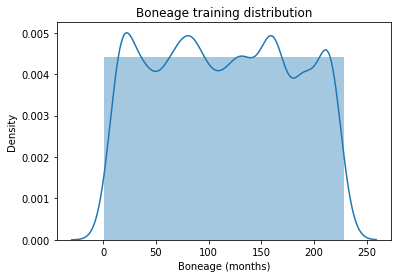

In [ ]:
# Group bone age into categories for resampling
df_train['boneage_category'] = pd.cut(df_train['boneage'], 10)
train_df = df_train.groupby(['boneage_category', 'gender2']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
val_df = df_val

fig, ax = plt.subplots()
ax = sns.distplot(train_df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density', title='Boneage training distribution');

In [ ]:
# Calculate custom metrics
mae_months = mae_months(y_true, y_pred, boneage_mean, boneage_std)
mae_months_male = mae_months(y_true, y_pred, male_boneage_mean, male_boneage_std)
mae_months_female = mae_months(y_true, y_pred, female_boneage_mean, female_boneage_std)

## Image Preprocessing

In [ ]:
# Enhance contrast of images and save images
enhance_img(train_path, train_path, df_train)

### Data Augmentation

In [ ]:
# Instantiate generators
train_idg = idg(
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 20,
    shear_range = 0.2,
    fill_mode = 'nearest',
    zoom_range = 0.2
    )

test_idg = idg()

# Generate inputs for images (single input, all data)
train_img_inputs = gen_img_inputs(train_idg, df_train, train_path, batch_size_train, True, img_size)
val_img_inputs = gen_img_inputs(test_idg, df_val, val_path, batch_size_val, False, img_size)
test_img_inputs = gen_img_inputs(test_idg, df_test, test_path, batch_size_test, False, img_size)

# Generate inputs for images (single input, sex-specific data)
male_train_img_inputs = gen_img_inputs(train_idg, df_train_male, train_path, batch_size_train, True, img_size)
male_val_img_inputs = gen_img_inputs(test_idg, df_val_male, val_path, batch_size_val, False, img_size)
male_test_img_inputs = gen_img_inputs(test_idg, df_test_male, test_path, batch_size_test, False, img_size)

female_train_img_inputs = gen_img_inputs(train_idg, df_train_female, train_path, batch_size_train, True, img_size)
female_val_img_inputs = gen_img_inputs(test_idg, df_val_female, val_path, batch_size_val, False, img_size)
female_test_img_inputs = gen_img_inputs(test_idg, df_test_female, test_path, batch_size_test, False, img_size)

# Generate inputs for images & sex variables (two inputs)
train_img_sex_inputs = gen_img_sex_inputs(train_idg, df_train, train_path, batch_size_train, True, img_size)
val_img_sex_inputs = gen_img_sex_inputs(test_idg, df_val, val_path, batch_size_val, False, img_size)
test_img_sex_inputs = gen_img_sex_inputs(test_idg, df_test, test_path, batch_size_test, False, img_size)

# Modeling

In [ ]:
# Instantiate optimizer
optim = optimizer(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0)

In [ ]:
# Instantiate callbacks
callbacks = callbacks(factor=0.8, patience=5, min_lr=1e-6)

## Model 1: Baseline Model
#### Convolutional base (pre-trained CNN (Xception)) with fully connected layers

In [ ]:
# Build & compile model
baseline_model = baseline_model(img_dims, tanh, optim, [mae_months])
baseline_model.summary()

In [ ]:
# Train model with convolutional base frozen initially
baseline_history1 = baseline_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )

In [ ]:
# Fine-tune: unfreeze last 2 convolutional blocks of base model & re-train these layers along with additional networks
# Lower learning rate
baseline_model = fine_tune(model=baseline_model, lr=0.0001, metric=[mae_months])

# Re-train model
baseline_history2 = baseline_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )

In [ ]:
# Plot training history
plot_history(baseline_history2)

### Model 1a: Baseline Model for Males Only

In [ ]:
# Build & compile model
male_model = baseline_model(img_dims, tanh, optim, [mae_months_male])
male_model.summary()

In [ ]:
# Train model - MALE
history_male = male_model.fit(
    male_train_img_inputs,
    validation_data = male_val_img_inputs,
    epochs = 10,
    callbacks = callbacks
    )

Epoch 1/10
214/214 [==============================] - 359s 2s/step - loss: 0.8476 - mae_months_male: 27.3654 - val_loss: 0.5362 - val_mae_months_male: 23.4069
Epoch 2/10
214/214 [==============================] - 360s 2s/step - loss: 0.3109 - mae_months_male: 17.6283 - val_loss: 0.2978 - val_mae_months_male: 18.7142
Epoch 3/10
214/214 [==============================] - 354s 2s/step - loss: 0.2207 - mae_months_male: 15.0862 - val_loss: 0.1650 - val_mae_months_male: 12.6315
Epoch 4/10
214/214 [==============================] - 351s 2s/step - loss: 0.1897 - mae_months_male: 14.0427 - val_loss: 0.1802 - val_mae_months_male: 13.4319
Epoch 5/10
214/214 [==============================] - 356s 2s/step - loss: 0.1605 - mae_months_male: 12.8682 - val_loss: 0.1527 - val_mae_months_male: 12.1179
Epoch 6/10
214/214 [==============================] - 349s 2s/step - loss: 0.1587 - mae_months_male: 12.8175 - val_loss: 0.1307 - val_mae_months_male: 11.4361
Epoch 7/10
214/214 [==========================

Text(0.5, 1.0, 'Training and validation MAE')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

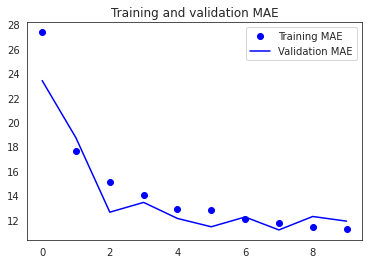

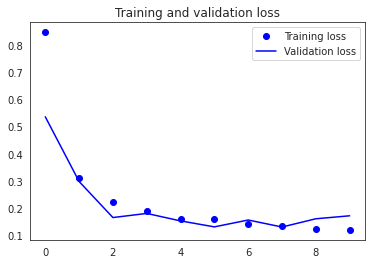

In [ ]:
plot_history(history_male)

### Model 1b. Baseline Model for Females Only

In [ ]:
# Build & compile model
male_model = baseline_model(img_dims, tanh, optim, [mae_months_male])
male_model.summary()

In [ ]:
# Train model - MALE
history_female = female_model.fit(
    female_train_img_inputs,
    validation_data = female_val_img_inputs,
    epochs = 10,
    callbacks = callbacks
    )

In [ ]:
plot_history(history_female)

## Model 2: Attention Mechanism
#### Convolutional base (pre-trained CNN (Xception)) with attention mechanism and additional fully connected layers

In [ ]:
# Build & compile model
attn_model = attn_model(img_dims, optim, [mae_months])
attn_model.summary()

In [ ]:
# Train model with convolutional base frozen
attn_history1 = attn_model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=val_generator,
    validation_steps=step_size_val,
    epochs=5,
    callbacks=callbacks
    )

Epoch 1/5
197/197 [==============================] - 2436s 12s/step - loss: 0.5612 - mae_months: 23.2615 - val_loss: 0.5654 - val_mae_months: 23.4362
Epoch 2/5
197/197 [==============================] - 680s 3s/step - loss: 0.4980 - mae_months: 20.6419 - val_loss: 0.4280 - val_mae_months: 17.7415
Epoch 3/5
197/197 [==============================] - 685s 3s/step - loss: 0.4696 - mae_months: 19.4646 - val_loss: 0.4862 - val_mae_months: 20.1557
Epoch 4/5
197/197 [==============================] - 712s 4s/step - loss: 0.4639 - mae_months: 19.2286 - val_loss: 0.4047 - val_mae_months: 16.7759
Epoch 5/5
197/197 [==============================] - 684s 3s/step - loss: 0.4541 - mae_months: 18.8227 - val_loss: 0.3894 - val_mae_months: 16.1412


In [ ]:
# Fine-tune
attn_model = fine_tune(model=attn_model, lr=0.0001, metric=[mae_months])

# Re-train model
attn_history2 = attn_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )

Epoch 1/20
197/197 [==============================] - ETA: 0s - loss: 0.4101 - mae_months: 16.9984Found 1425 validated image filenames.
Found 1425 validated image filenames.
197/197 [==============================] - 1251s 6s/step - loss: 0.4101 - mae_months: 16.9984 - val_loss: 0.3843 - val_mae_months: 15.9286
Epoch 2/20
197/197 [==============================] - 1239s 6s/step - loss: 0.3606 - mae_months: 14.9458 - val_loss: 0.3824 - val_mae_months: 15.8525
Epoch 3/20
197/197 [==============================] - 1249s 6s/step - loss: 0.3462 - mae_months: 14.3486 - val_loss: 0.3308 - val_mae_months: 13.7115
Epoch 4/20
197/197 [==============================] - 1252s 6s/step - loss: 0.3335 - mae_months: 13.8246 - val_loss: 0.2999 - val_mae_months: 12.4322
Epoch 5/20
197/197 [==============================] - 1290s 7s/step - loss: 0.3250 - mae_months: 13.4720 - val_loss: 0.4091 - val_mae_months: 16.9569
Epoch 6/20
197/197 [==============================] - 1333s 7s/step - loss: 0.3152 - ma

Text(0.5, 1.0, 'Training and validation MAE')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

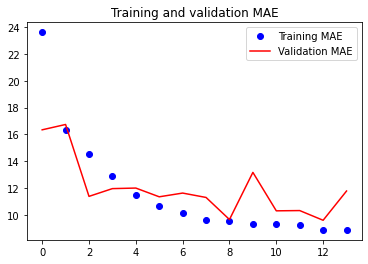

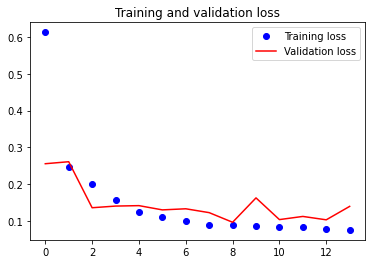

In [ ]:
plot_history(attn_history2)

## Model 3: Sex as Feature

In [ ]:
# Build & compile model
sex_model = sex_model(img_dims, optim, [mae_months])
sex_model.summary()

In [ ]:
# Train model with convolutional base frozen
sex_history1 = sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )

In [ ]:
# Fine-tune
sex_model = fine_tune(model=sex_model, lr=0.0001, metric=[mae_months])

# Re-train model
sex_history2 = sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )

In [ ]:
# Plot training history
plot_history(sex_history2)

## Model 4: Attention Mechanism, Sex as Feature

In [ ]:
# Build & compile model
attn_sex_model = attn_sex_model(img_dims, optim, [mae_months])
attn_sex_model.summary()

In [ ]:
# Train model with convolutional base frozen
attn_sex_history1 = attn_sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )

In [ ]:
# Fine-tune
attn_model = fine_tune(model=attn_sex_model, lr=0.0001, metric=[mae_months])

# Re-train model
attn_sex_history2 = attn_sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )

In [ ]:
# Plot training history
plot_history(attn_sex_history2)